# Online Finetuning using the adjoint SDE

We are using the technique proposed in:
1. Li et al.: Scalable Gradients for Stochastic Differential Equations (https://arxiv.org/pdf/2001.01328.pdf)
2. Kidger et al.:Efficient and Accurate Gradients for Neural SDEs (https://arxiv.org/pdf/2105.13493.pdf)

and implemented in the torchsde (see the documentation https://github.com/google-research/torchsde/blob/master/DOCUMENTATION.md#adjoints). 

## Specific example 

We use a score-based model trained on the MNIST dataset with $n = 784$ dimensions. We are looking at a compressed sensing example, i.e., $y = A x + \eta$ with a $m \times n, m << n$ matrix with $A_{i,j} \sim \mathcal{N}(0,1/m)$. The matrix $A$ is created once and then fixed for the experiment. 

In [1]:
import torch
import torchsde

import numpy as np 
import matplotlib.pyplot as plt 
import os 
import yaml 

import torch 
import torch.nn as nn 

from torchvision.datasets import MNIST
from torchvision import transforms 
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from tqdm import tqdm 

from src import TinyUnet, VPSDE, BaseSampler, Euler_Maruyama_sde_predictor

/home/adenker/anaconda3/envs/diffusion/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load pre trained score-based model (trained with score matching)

base_path = "model_weights"

with open(os.path.join(base_path, "report.yaml"), "r") as f:
    cfg_dict = yaml.safe_load(f)

sde = VPSDE(beta_min=cfg_dict["diffusion"]["beta_min"], 
            beta_max=cfg_dict["diffusion"]["beta_max"]
            )

model = TinyUnet(
            marginal_prob_std=sde.marginal_prob_std, 
            time_embedding_dim=cfg_dict["model"]["time_embedding_dim"],
            max_period=cfg_dict["model"]["max_period"],
            in_channels=cfg_dict["model"]["in_channels"],
            out_channels=cfg_dict["model"]["out_channels"],
            base_dim=cfg_dict["model"]["base_dim"],
            dim_mults=cfg_dict["model"]["dim_mults"])
model.load_state_dict(torch.load("model_weights/model.pt"))
model.to("cuda")
model.eval()

TinyUnet(
  (init_conv): ConvBnSiLu(
    (module): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
  )
  (time_embed): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (encoder_blocks): ModuleList(
    (0): EncoderBlock(
      (conv0): Sequential(
        (0): ResidualBottleneck(
          (branch1): Sequential(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ConvBnSiLu(
              (module): Sequential(
                (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
                (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_ru

In [3]:
# load data and create forward operator

val_dataset = MNIST(root="./mnist_data",
                        train=False,
                        download=True,
                        transform = transforms.ToTensor()
                        )


x_gt = val_dataset[0][0].unsqueeze(0).to("cuda")

m = x_gt.numel()/2
A = torch.randn([int(m), int(x_gt.numel())])/torch.sqrt(torch.tensor(m))
A = A.to("cuda")

def Afwd(x, A=A):

    tmp = x.view(x.shape[0], -1)

    return torch.matmul(tmp, A.T)

def Abwd(y, A=A):

    tmp = torch.matmul(y, A)

    return tmp.view(tmp.shape[0], 1, 28, 28)

y = Afwd(x_gt)
y_noise = y + 0.01*torch.mean(y)*torch.rand_like(y)
ATy = Abwd(y_noise)

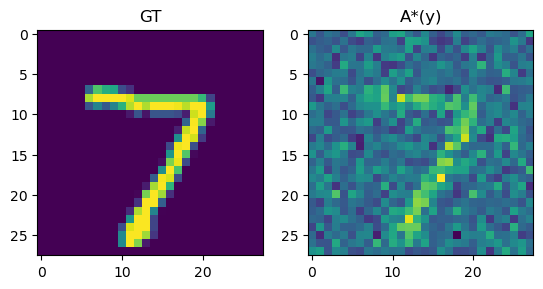

In [4]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.imshow(x_gt.cpu()[0,0,:,:])
ax1.set_title("GT")

ax2.imshow(ATy.cpu()[0,0,:,:])
ax2.set_title("A*(y)")

plt.show()

In [ ]:
# define Ito SDE
# define the reverse SDE for sampling
# dx = (f(x,t) - g(t)^2 s(x,t) - g(t)^2 h(x, t)) dt+ g(t) dw
# However, torchsde can only deal with increasing time sequences
# so, we have to look at dx = - (f(x, 1-t) - g(1-t)^2 s(x, 1-t) - g(1-t)^2 h(x, 1-t)) dt + g(1-t) dw 
# s pretrained score, h finetune score
# further, we have to audgment the SDE to output || h(x,t) || (i.e. add one extra state with g(t)=0)

class SDE(torch.nn.Module):
    noise_type = 'diagonal'
    sde_type = 'ito'

    def __init__(self, model, sde, y_noise):
        super().__init__()
        self.noise_type = "diagonal"
        self.sde_type = "ito"

        self.model = model 
        self.sde = sde 
        self.cond_model = TinyUnet(
            marginal_prob_std=sde.marginal_prob_std, 
            time_embedding_dim=cfg_dict["model"]["time_embedding_dim"],
            max_period=cfg_dict["model"]["max_period"],
            in_channels=1,
            out_channels=cfg_dict["model"]["out_channels"],
            base_dim=16,
            dim_mults=[1,2])
        self.cond_model.to("cuda")
        self.cond_model.train() 

        self.y_noise = y_noise
    # Drift
    def f(self, t, y):
        y = y[:, :-1]

        #print(1.0 - t)
        ones_vec = torch.ones(y.shape[0], device=y.device)
        t = ones_vec * t
        
        s_pretrained = self.model(y.view(y.shape[0], 1, 28,28), 1.0 - t)
        
        cond = torch.repeat_interleave(self.y_noise,  dim=0, repeats=y.shape[0])
        log_grad = Abwd(Afwd(y.view(y.shape[0], 1, 28,28)) - cond)
        s_new = self.cond_model(log_grad, 1.0 - t)

        s = s_pretrained + s_new

        drift, diffusion = self.sde.sde(y.view(y.shape[0], 1, 28,28), 1.0 - t)

        mu = drift - diffusion[:, None, None, None].pow(2)*s

        beta_t = self.sde.beta_0 + (1.0 - t) * (self.sde.beta_1 - self.sde.beta_0)
        f_sq = beta_t.unsqueeze(1)*(s_new ** 2).sum(dim=(1,2,3)).unsqueeze(1)

        drift = -mu.view(y.shape[0], -1)
        
        return torch.cat([drift, f_sq], dim=1)

    # Diffusion
    def g(self, t, y):
        y = y[:, :-1]
        ones_vec = torch.ones(y.shape[0], device=y.device)
        t = ones_vec * t
        drift, diffusion = self.sde.sde(y.view(y.shape[0], 1, 28,28), 1.0 - t)

        diffusion_rep = diffusion[:,None].repeat(1, y.shape[-1])
        return torch.cat([diffusion_rep, torch.zeros((y.shape[0], 1), device=y.device)], dim=1)

